In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-12-13 14:02:27.378868: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 14:02:27.416642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 14:02:27.416669: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 14:02:27.416686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 14:02:27.426846: I tensorflow/core/platform/cpu_feature_g

In [2]:
from tools.visualization import plot_image
from tools.data_loading import load_numpy_data
from defs.storage_locs import ALL_DATASETS_NAMES, weights_file

# Load Data

In [3]:
test_filename = 'test'
train_filename = 'train'
no_aug_train_filename = 'noaug_train'
no_aug_test_filename = 'noaug_test'
right_orient_train_filename = 'right_orient_train'
right_orient_test_filename = 'right_orient_test'
sub_directory = '20231129'
size = '480x270'
weights_filename = 'ResNet50v2_right.h5'

In [4]:
all_test_X, all_test_Y = load_numpy_data(test_filename, size, save=False, input_dirname=sub_directory)
all_train_X, all_train_Y = load_numpy_data(train_filename, size, save=False, input_dirname=sub_directory)
noaug_train_X, noaug_train_Y = load_numpy_data(no_aug_train_filename, size, save=False, input_dirname=sub_directory)
noaug_test_X, noaug_test_Y = load_numpy_data(no_aug_test_filename, size, save=False, input_dirname=sub_directory)
right_orient_train_X, right_orient_train_Y = load_numpy_data(right_orient_train_filename, size, save=False, input_dirname=sub_directory)
right_orient_test_X, right_orient_test_Y = load_numpy_data(right_orient_test_filename, size, save=False, input_dirname=sub_directory)

In [5]:
print(all_train_X.shape)
print(all_train_Y.shape)

(1428, 270, 480, 3)
(1428, 20)


In [6]:
points = [1,2,3,4,5,6] # points to be predicted
point_cols = [(2 * (p-1), 2 * (p-1) + 1) for p in points]
point_cols = np.array(point_cols).flatten()
all_test_Y = all_test_Y[:, point_cols]
all_train_Y = all_train_Y[:, point_cols]
noaug_test_Y = noaug_test_Y[:, point_cols]
noaug_train_Y = noaug_train_Y[:, point_cols]
right_orient_test_Y = right_orient_test_Y[:, point_cols]
right_orient_train_Y = right_orient_train_Y[:, point_cols]
print(all_test_Y.shape)

(372, 12)


In [7]:
X_datasets = [all_test_X, all_train_X, noaug_train_X, noaug_test_X, right_orient_train_X, right_orient_test_X]
Y_datasets = [all_test_Y, all_train_Y, noaug_train_Y, noaug_test_Y, right_orient_train_Y, right_orient_test_Y]
dataset_names = ['all_test', 'all_train', 'noaug_train', 'noaug_test', 'right_orient_train', 'right_orient_test']
dataset_index = {dataset_names[i]: i for i in range(len(dataset_names))}


# Define and Load Model

In [8]:
shape = all_test_X[0].shape
print(shape)
num_points = all_test_Y.shape[1]
print(num_points)

(270, 480, 3)
12


In [9]:
bm = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
)

inputs = tf.keras.Input(shape=shape)
x = bm(inputs, training=False)
# x.trainable = False
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_points, activation = 'relu')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

2023-12-13 14:02:35.539078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 14:02:35.546125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 14:02:35.546554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 14:02:35.549765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 14:02:35.550164: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 270, 480, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 9, 15, 2048)       23564800  
                                                                 
 flatten (Flatten)           (None, 276480)            0         
                                                                 
 dropout (Dropout)           (None, 276480)            0         
                                                                 
 dense (Dense)               (None, 12)                3317772   
                                                                 
Total params: 26882572 (102.55 MB)
Trainable params: 26837132 (102.38 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae'])

In [11]:
# load weights
print(weights_file(weights_filename))
model.load_weights(weights_file(weights_filename))

/mnt/f/SeniorProject/weights/ResNet50v2_right.h5


# Predictions

In [12]:
predictions = []
for i in range(len(X_datasets)):
    X = X_datasets[i]
    Y = Y_datasets[i]
    dataset_name = dataset_names[i]
    print(dataset_name)
    print(X.shape)
    print(Y.shape)
    if 'test' in dataset_name:
        predictions.append(model.predict(X))
    else:
        predictions.append([])

all_test
(372, 270, 480, 3)
(372, 12)


2023-12-13 14:02:41.154157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-13 14:02:42.339740: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/12 [=>............................] - ETA: 59s

2023-12-13 14:02:44.715448: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


12/12 [==============================] - 9s 352ms/step
all_train
(1428, 270, 480, 3)
(1428, 12)
noaug_train
(476, 270, 480, 3)
(476, 12)
noaug_test
(124, 270, 480, 3)
(124, 12)
4/4 [==============================] - 2s 809ms/step
right_orient_train
(714, 270, 480, 3)
(714, 12)
right_orient_test
(186, 270, 480, 3)
(186, 12)
6/6 [==============================] - 3s 568ms/step


## Collect Statistics

In [13]:
def average_distance_error(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, 6, 2))
    y_pred = tf.reshape(y_pred, (-1, 6, 2))
    # Calculate Euclidean distance between each pair of coordinates
    distances = tf.norm(y_true - y_pred, axis=-1)
    loss = tf.reduce_mean(distances)
    return loss.numpy()

def mean_average_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def average_max_distance_error(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, 6, 2))
    y_pred = tf.reshape(y_pred, (-1, 6, 2))
    # Calculate Euclidean distance between each pair of coordinates
    distances = tf.norm(y_true - y_pred, axis=-1)
    max_distances = tf.reduce_max(distances, axis=-1)
    loss = tf.reduce_mean(max_distances)
    return loss.numpy()

def average_distance_errors(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, 6, 2))
    y_pred = tf.reshape(y_pred, (-1, 6, 2))
    # Calculate Euclidean distance between each pair of coordinates
    distances = tf.norm(y_true - y_pred, axis=-1)
    avg_distances = tf.reduce_mean(distances, axis=-1)
    return avg_distances.numpy()

def max_distance_errors(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, 6, 2))
    y_pred = tf.reshape(y_pred, (-1, 6, 2))
    # Calculate Euclidean distance between each pair of coordinates
    distances = tf.norm(y_true - y_pred, axis=-1)
    max_distances = tf.reduce_max(distances, axis=-1)
    return max_distances.numpy()

In [14]:
data = pd.DataFrame(columns=['MAE', 'MSE', 'AvgDist', 'AvgMaxDistance'], index=dataset_names)
max_errors = []
avg_errors = []
for i in range(len(X_datasets)):
    dataset_name = dataset_names[i]
    X = X_datasets[i]
    Y = Y_datasets[i]
    pred = predictions[i]
    values = []
    if 'test' in dataset_name:
        values.append(mean_average_error(Y, pred))
        values.append(mean_squared_error(Y, pred))
        values.append(average_distance_error(Y, pred))
        values.append(average_max_distance_error(Y, pred))
        data.loc[dataset_name] = values

        max_errors.append(max_distance_errors(Y, pred))
        avg_errors.append(average_distance_errors(Y, pred))
    else:
        max_errors.append([])
        avg_errors.append([])
data

,MAE,MSE,AvgDist,AvgMaxDistance
all_test,187.514679,142655.046875,329.471527,800.8797
all_train,NaN,NaN,NaN,NaN
noaug_train,NaN,NaN,NaN,NaN
noaug_test,179.755539,141817.640625,328.329315,800.806091
right_orient_train,NaN,NaN,NaN,NaN
right_orient_test,33.01535,1679.841797,51.068455,96.804802


In [15]:
print(data.to_latex())

\begin{tabular}{lllll}
\toprule
 & MAE & MSE & AvgDist & AvgMaxDistance \\
\midrule
all_test & 187.514679 & 142655.046875 & 329.471527 & 800.879700 \\
all_train & NaN & NaN & NaN & NaN \\
noaug_train & NaN & NaN & NaN & NaN \\
noaug_test & 179.755539 & 141817.640625 & 328.329315 & 800.806091 \\
right_orient_train & NaN & NaN & NaN & NaN \\
right_orient_test & 33.015350 & 1679.841797 & 51.068455 & 96.804802 \\
\bottomrule
\end{tabular}



## See worst predictions

In [16]:
from court_segment.plot_court_labels import plot_labels

In [17]:
dataset_name = 'right_orient_test'
index = dataset_index[dataset_name]
print(index)
my_max_errors = max_errors[index]
my_avg_errors = avg_errors[index]

5


### Worst max

In [18]:
count = 5
worst_max_indices = np.argsort(my_max_errors)[-count:][::-1]
print('worst max indices:', worst_max_indices)
print('train max errors:', my_max_errors[worst_max_indices])

worst max indices: [ 69  65  81  73 158]
train max errors: [137.19061 133.67827 132.7316  130.75218 130.4383 ]


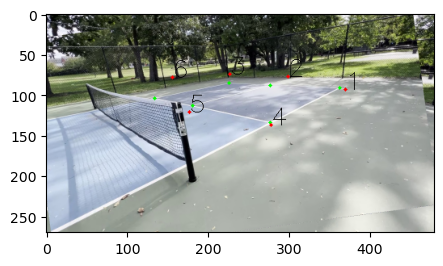

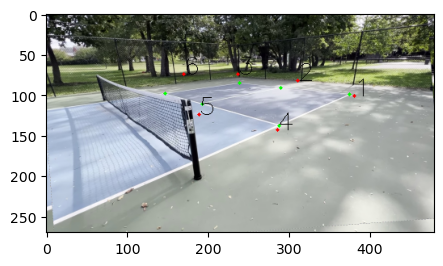

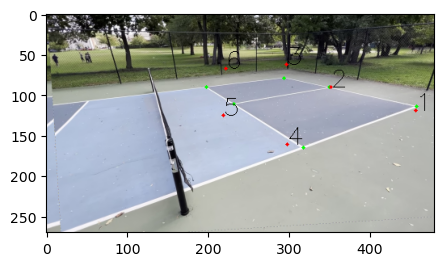

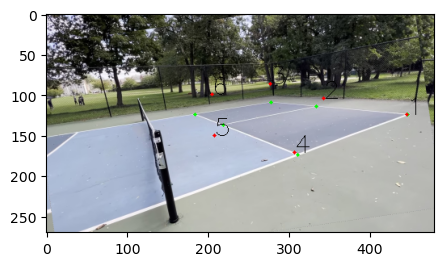

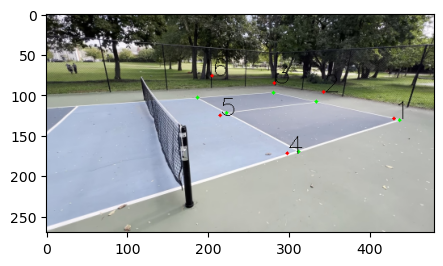

In [19]:
for i in worst_max_indices:
    correct_labels = plot_labels(X_datasets[index][i], Y_datasets[index][i], withText=False)
    all_labels = plot_labels(correct_labels, predictions[index][i], color=(255, 0,0))
    plot_image(all_labels, figsize=(5,5))

### Worst Average

In [20]:
count = 5
worst_avg_indices = np.argsort(my_avg_errors)[-count:][::-1]
print('worst avg indices:', worst_avg_indices)
print('worst avg errors:', my_avg_errors[worst_avg_indices])

worst avg indices: [ 67  47  34 103  58]
worst avg errors: [77.070526 67.773125 66.45161  65.877266 65.608154]


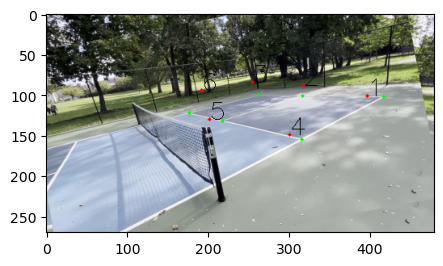

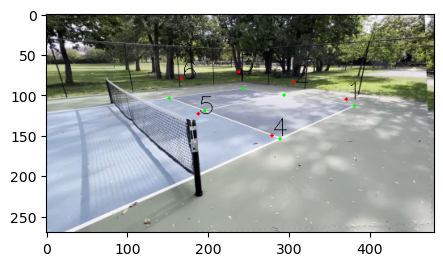

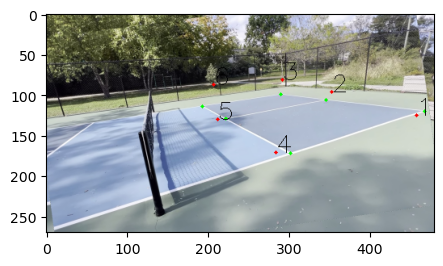

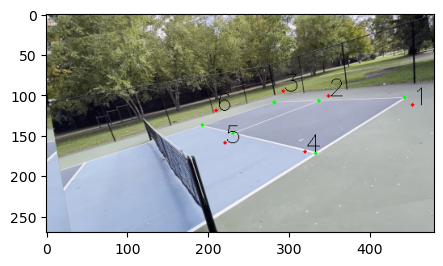

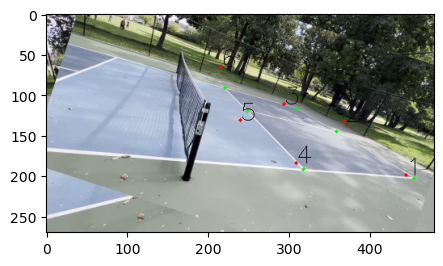

In [21]:
for i in worst_avg_indices:
    correct_labels = plot_labels(X_datasets[index][i], Y_datasets[index][i], withText=False)
    all_labels = plot_labels(correct_labels, predictions[index][i], color=(255,0,0))
    plot_image(all_labels, figsize=(5,5))

## Interactive Testing

In [22]:
from court_segment.plot_court_labels import plot_random_labeled_image

In [23]:
dataset_name = 'all_train'
index = dataset_index[dataset_name]
X = X_datasets[index]
Y = Y_datasets[index]
pred = predictions[index]
plot_random_labeled_image(X, pred, withLines=True, show_axes=False)

AttributeError: 'list' object has no attribute 'shape'

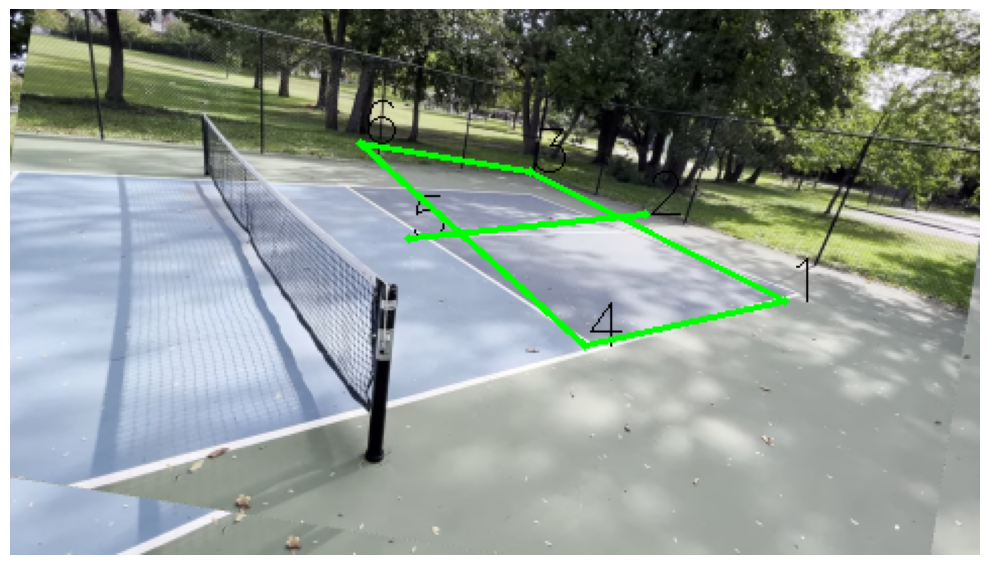

In [48]:
dataset_name = 'right_orient_test'
index = dataset_index[dataset_name]
X = X_datasets[index]
Y = Y_datasets[index]
pred = predictions[index]
plot_random_labeled_image(X, pred, withLines=True, show_axes=False)

## Try with new dataset

In [25]:
from tools.image_extract import read_frames
from defs.storage_locs import raw_video_path

In [26]:
frames = [i for i in range(0, 1500, 50)]
vid_path = raw_video_path('court', 'center_right_2_shady.MOV')
X_new = read_frames(vid_path, frames, resize_to=(shape[1],shape[0]))
X_new.shape

(13, 270, 480, 3)

In [27]:
y_new = model.predict(X_new)
y_new.shape

1/1 [==============================] - 1s 1s/step


(13, 12)

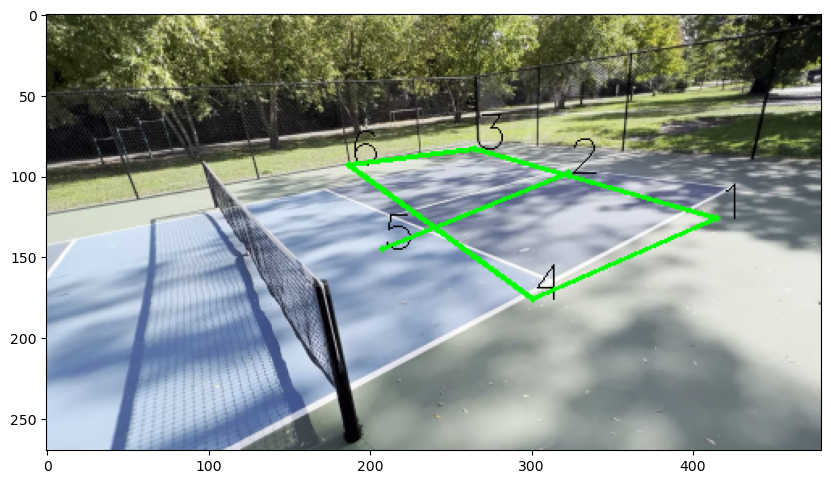

In [28]:
plot_random_labeled_image(X_new, y_new, withLines=True)

horrible...

What about with same dataset but new frames?

In [29]:
frames = [i for i in range(1200, 1500, 50)]
vid_path = raw_video_path('court', 'center_right_1.MOV')
X_new = read_frames(vid_path, frames, (shape[1],shape[0]))
X_new.shape

(6, 270, 480, 3)

In [30]:
y_new = model.predict(X_new)

1/1 [==============================] - 1s 790ms/step


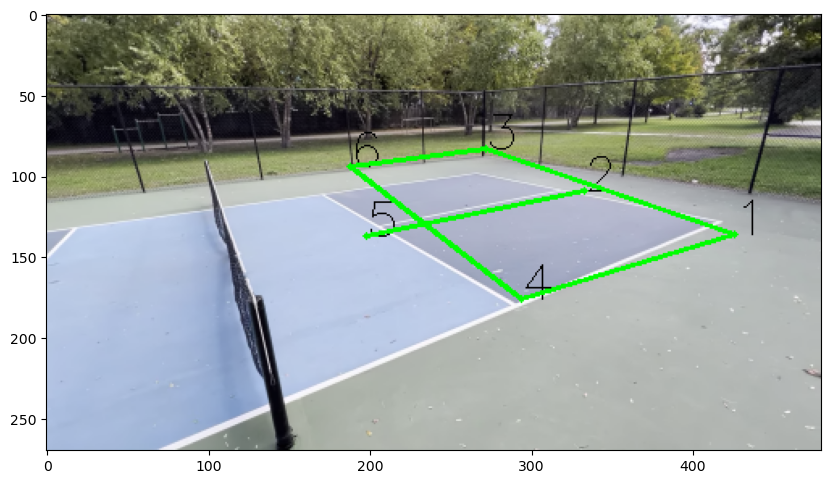

In [38]:
plot_random_labeled_image(X_new, y_new, withLines=True)